# Prepping the final steps of PaddockTS
## These are the steps:
1. Import the data based on a "stub" identifier
    - time series Sentinel 1/2 after preprocessing and index calculations (*ds2i.pkl, *ds1.pkl) [note: Sentinel-1 is not currently implemented as not used currently in phenology inference]
    - paddock boundaries (*_filt.gpkg)
2. Aggregate the time series data to paddocks; save the paddock time series  as *_paddockTS_raw.pkl 
3. Resample, interpolate and smooth paddock time series
4. Break time series into "paddock years"
5. [possible add-in for later] filter paddock years with long stretches of missing data
6. Calculate phenology metrics for each paddock-year using phenolopy (https://github.com/lewistrotter/PhenoloPy/tree/main), which is a python implementation of TIMESAT (https://web.nateko.lu.se/timesat/timesat.asp)
7. [possible add-in for later] predict crop type (or crop/grazing/tree/other) using a classification model that should be trained and evaluated.
8. [possible add-in for later] predict flowering time for Canola/others (but this requires at least a rudimentary crop type classifier)
9. Plot paddock-year time series with raw/interpolated NDVI, and mark-up the estimated Start of Season (SoS), Peak of Season (PoS) and End of Season (EoS). (save as: ______)
10. Save the paddock phenolotrics (*_paddock_phenology_metrics.csv)

The steps are currently working and it's ready to convert into a .py script. 

Scroll down to MAIN to see where the steps are implemented.

This notebook has been tested with:
- stub = "TEST8", which is 2022-2023 for a cropping region.

In [1]:
# Most of these libs are doubled up below... 

import numpy as np
import pickle
import xarray as xr
import rioxarray  # activate the rio accessor
import matplotlib.pyplot as plt 
import rasterio
import os
import shutil
import geopandas as gpd


from affine import Affine
from rasterstats import zonal_stats
from concurrent.futures import ProcessPoolExecutor
from functools import partial

In [2]:
## Functions for aggregating the paddock time series
# This is a different approach to what I used previously (chatGPT), and I have not compared for efficiency. Doesn't matter for small datasets, and probably not worth worrying about. 

import numpy as np
import xarray as xr
from affine import Affine
from rasterstats import zonal_stats
from concurrent.futures import ProcessPoolExecutor
from functools import partial

def compute_median_for_time(t, band_array, transform, geometries):
    """
    Helper function that computes the zonal median for a single time step.
    
    Parameters:
        t (int): The time index.
        band_array (np.ndarray): A 3D numpy array (time, y, x) for the band.
        transform (Affine): Affine transform for the spatial mapping.
        geometries (list): List of shapely geometry objects.
    
    Returns:
        list: A list of median values, one for each geometry.
    """
    arr = band_array[t, :, :]
    stats = zonal_stats(
        vectors=geometries, 
        raster=arr, 
        affine=transform, 
        stats=['median'],
        nodata=np.nan
    )
    return [stat['median'] for stat in stats]

def summarize_medians_by_paddock(ds, pol):
    """
    Computes the median of each band in the xarray dataset 'ds' for each time step,
    over the areas defined by the geometries in the geopandas DataFrame 'pol',
    using parallel processing to speed up the computation.
    The resulting dataset uses the 'paddock' column (converted to string) of 'pol' as a coordinate.
    
    Parameters:
        ds (xarray.Dataset): Input dataset with dimensions (time, y, x) and band variables.
        pol (geopandas.GeoDataFrame): DataFrame with a 'geometry' column and a 'paddock' column.
        
    Returns:
        xarray.Dataset: A new dataset with coordinates 'paddock' and 'time'. Each variable is
                        named <band>_median and holds the median values computed for each paddock
                        and time step.
    """
    # Create an affine transform from the xarray coordinates.
    x = ds.coords['x'].values
    y = ds.coords['y'].values
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    transform = Affine.translation(x[0] - dx/2, y[0] - dy/2) * Affine.scale(dx, dy)
    
    # Convert paddock identifiers to strings.
    paddock_labels = pol.paddock.astype(str)
    
    # Prepare an empty dataset using the paddock names and time coordinates.
    ds_paddocks = xr.Dataset(coords={
        'paddock': paddock_labels,
        'time': ds.coords['time']
    })
    
    # Prepare the list of geometries (ensuring they are picklable for parallel processing).
    geometries = list(pol['geometry'])
    
    # Loop over each band variable in the dataset.
    for band in ds.data_vars:
        medians = np.empty((len(pol), ds.sizes['time']))
        band_array = ds[band].values  # shape: (time, y, x)
        
        # Create a partial function that fixes band_array, transform, and geometries.
        func = partial(compute_median_for_time, band_array=band_array, 
                       transform=transform, geometries=geometries)
        
        # Use parallel processing to compute the zonal median for each time step.
        with ProcessPoolExecutor() as executor:
            results = list(executor.map(func, range(ds.sizes['time'])))
        
        # Populate the medians array.
        for t, med in enumerate(results):
            medians[:, t] = med
        
        # Add the median values as a new variable in the output dataset.
        ds_paddocks[band] = (('paddock', 'time'), medians)
    
    return ds_paddocks

# Example usage:
# ds_paddocks = summarize_medians_by_paddock(ds, pol)
# print(ds_paddocks)

In [3]:
def resample_interpolate_smooth_paddocks(ds,
                                         days=10,
                                         window_length=7,
                                         polyorder=2):
    """
    Resample, conservatively interpolate, and smooth all time-dependent
    variables in a paddock-time xarray Dataset.

    The logic is identical to my function from ACT trees project:
      1. Separate non-time-dependent variables.
      2. Resample time-dependent data every `days` days (median).
      3. Interpolate missing values with PCHIP (conservative).
      4. Smooth with Savitzky–Golay.
      5. Re-attach static variables and return the new dataset.

        Parameters
    ----------
    ds : xarray.Dataset
        The input dataset.
    days : int, optional
        The resampling frequency in days (default is 10).
    window_length : int, optional
        The window length for the Savitzky–Golay filter (default is 7). This value must be odd. This is how many resampled obs the polynomial is fit to. 
    polyorder : int, optional
        The polynomial order for the Savitzky–Golay filter (default is 2). should be smaller than window_length. Higher orders let the filter follow curvature more closely but can re-introduce noise if the window is too short.
    """
    import numpy as np
    import xarray as xr
    from scipy.interpolate import PchipInterpolator
    from scipy.signal import savgol_filter

    # ─────────────────────────── 1. split vars ────────────────────────────
    time_dependent_vars = [v for v in ds.data_vars if "time" in ds[v].dims]
    non_time_dependent_vars = [v for v in ds.data_vars
                               if v not in time_dependent_vars]

    ds_non_time = ds[non_time_dependent_vars]  # may be empty
    ds_time_dep = ds[time_dependent_vars]

    # ─────────────────── 2. resample on a fixed grid ──────────────────────
    ds_resampled = ds_time_dep.resample(time=f"{days}D").median()
    ds_resampled = ds_resampled.transpose("paddock", "time")

    # ─────────────────── 3. interpolate with PCHIP ────────────────────────
    interp_dict = {}
    x = np.arange(ds_resampled.time.size)

    for var in time_dependent_vars:                           # loop over bands
        data = ds_resampled[var].values                       # (paddock, time)
        data_interp = np.empty_like(data, dtype=np.float64)

        for i in range(data.shape[0]):                        # loop paddocks
            y = data[i]
            valid = np.isfinite(y)                            # NaN or ±Inf safe
            if valid.sum() >= 2:
                try:
                    f = PchipInterpolator(x[valid], y[valid],
                                          extrapolate=True)
                    data_interp[i] = f(x)
                except ValueError:        # PCHIP can still fail (e.g. all equal)
                    data_interp[i] = np.nanmean(y) if valid.any() else np.nan
            else:
                data_interp[i] = np.nanmean(y) if valid.any() else np.nan

        # ─────────────── 4. Savitzky–Golay smoothing ────────────────
        wl = window_length + (window_length + 1) % 2           # make odd
        wl = min(wl, data_interp.shape[1] | 1)                 # ≤ n_time & odd
        data_smoothed = savgol_filter(data_interp,
                                      window_length=wl,
                                      polyorder=polyorder,
                                      axis=-1)
        interp_dict[var] = (("paddock", "time"), data_smoothed)

    # ─────────────────── 5. rebuild dataset ───────────────────────────────
    ds_new = ds_resampled.copy()
    for var, da in interp_dict.items():
        ds_new[var] = da
    for var in non_time_dependent_vars:
        ds_new[var] = ds_non_time[var]

    # keep original coords that might have been dropped (e.g. spatial_ref)
    for c in ds.coords:
        if c not in ds_new.coords:
            ds_new = ds_new.assign_coords({c: ds[c]})

    return ds_new


In [4]:
def split_paddockTS_by_year(ds):
    """
    Split paddock time series data by year, add day of year (doy) coordinate, and check for duplicate dates.
    
    Args:
        ds (xarray.Dataset): The input dataset containing time series data for each paddock.
        
    Returns:
        dict: A dictionary where each key is a year (int), and the value is an xarray.Dataset for that year,
              with an added 'doy' coordinate.
    """
    # Identify unique years in the 'time' coordinate (sorted)
    years = np.unique(ds.time.dt.year.values)
    
    # Dictionary to store datasets for each year
    datasets_by_year = {}
    
    for year in years:
        # Select data for the given year
        ds_year = ds.sel(time=ds.time.dt.year == year)

        # Useful bit of code if there are S1 data present, which can cause multi-obs on single day. 
        # # Check for multiple observations on the same date
        # dates = ds_year.time.dt.date.values
        # unique_dates, counts = np.unique(dates, return_counts=True)
        # duplicate_dates = unique_dates[counts > 1]
        
        # if duplicate_dates.size > 0:
        #     print(f"Multiple observations found on date(s) in {year}: {duplicate_dates}")
        # else:
        #     print(f"All observations in {year} occur on unique dates.")
        
        # Add an attribute for the year
        ds_year.attrs['year'] = int(year)
        
        # Calculate day of year (doy) from 'time' and add it as a new coordinate
        doy = ds_year.time.dt.dayofyear.data  # use .data to extract the underlying array
        ds_year = ds_year.assign_coords(doy=('time', doy))
        
        # Store the dataset in the dictionary
        datasets_by_year[int(year)] = ds_year

    return datasets_by_year

# Example usage:
# ds_paddock_years = split_paddockTS_by_year(ds_paddocks_ind)
# print(ds_paddock_years)

In [5]:
# ## The functions in this block are no longer used, but worth keeping for now... 
# ## These attempt to recreate TIMESAT/phenolopy functions but using directly our style of paddock time series as input. 
# ## Eventually I replaced this with an approach that coerces our paddock time series data into a format directly compatible with the phenolopy functions (I prefer this updated appraoch)

# import pandas as pd
# import numpy as np
# import xarray as xr
# import math
# from scipy.signal import find_peaks


# def make_phenology_template(
#     ds_by_year: dict[int, xr.Dataset]
# ) -> pd.DataFrame:
#     """
#     Build a template DataFrame for storing phenology metrics for each
#     paddock and year.

#     Parameters
#     ----------
#     ds_by_year : dict[int, xr.Dataset]
#         Mapping from year to an xarray.Dataset, each containing a
#         'paddock' coordinate listing paddock IDs.

#     Returns
#     -------
#     pd.DataFrame
#         A DataFrame with one row per paddock-year, and columns:
#         - paddock: paddock ID
#         - year: calendar year
#         - n_peaks: number of phenological peaks (init NaN)
#         - SoS: start of season (day-of-year, init NaN)
#         - PoS_val: peak-of-season value (init NaN)
#         - PoS: peak-of-season time (day-of-year, init NaN)
#         - MOS: middle-of-season value (init NaN)
#         - EoS: end of season (day-of-year, init NaN)
#         - pred_crop: predicted crop type (init None)
#     """
#     records: list[dict] = []
#     for year, ds in ds_by_year.items():
#         paddocks = ds.coords["paddock"].values
#         for pad in paddocks:
#             records.append({
#                 "paddock": pad,
#                 "year": year,
#                 # placeholder metrics:
#                 "n_peaks": np.nan,
#                 "SoS": np.nan,
#                 "PoS_val": np.nan,
#                 "PoS": np.nan,
#                 "MOS": np.nan,
#                 "EoS": np.nan,
#                 "pred_crop": None,
#             })
#     cols = [
#         "paddock", "year", "n_peaks", "SoS",
#         "PoS_val", "PoS", "MOS", "EoS", "pred_crop"
#     ]
#     return pd.DataFrame.from_records(records, columns=cols)


# def add_num_peaks(
#     df: pd.DataFrame,
#     ds_by_year: dict[int, xr.Dataset],
#     var: str = "NDVI"
# ) -> pd.DataFrame:
#     """
#     Populate 'n_peaks' by counting peaks via scipy.find_peaks on each series.
#     """
#     for idx, row in df.iterrows():
#         ds = ds_by_year.get(row['year'])
#         if ds is None or var not in ds:
#             df.at[idx, 'n_peaks'] = 0
#             continue
#         series = ds[var].sel(paddock=row['paddock']).values
#         valid = np.isfinite(series)
#         if valid.sum() < 3:
#             df.at[idx, 'n_peaks'] = 0
#             continue
#         height = np.nanquantile(series[valid], 0.75)
#         dist = math.ceil(len(series)/4)
#         peaks, _ = find_peaks(series, height=height, distance=dist)
#         df.at[idx, 'n_peaks'] = len(peaks)
#     return df


# def add_peak_of_season(
#     df: pd.DataFrame,
#     ds_by_year: dict[int, xr.Dataset],
#     var: str = "NDVI"
# ) -> pd.DataFrame:
#     """Populate PoS_val and PoS with the max value and its day-of-year."""
#     for idx, row in df.iterrows():
#         ds = ds_by_year.get(row['year'])
#         if ds is None or var not in ds:
#             continue
#         da = ds[var].sel(paddock=row['paddock'])
#         # peak value and time
#         val = da.max('time', skipna=True).item()
#         t_idx = da.argmax('time', skipna=True).item()
#         time = int(da['time.dayofyear'].isel(time=t_idx))
#         df.at[idx, 'PoS_val'] = val
#         df.at[idx, 'PoS'] = time
#     return df


# def add_middle_of_season(
#     df: pd.DataFrame,
#     ds_by_year: dict[int, xr.Dataset],
#     var: str = "NDVI"
# ) -> pd.DataFrame:
#     """
#     Populate MOS with the mean of the upper 80% slopes around the peak.
#     """
#     for idx, row in df.iterrows():
#         ds = ds_by_year.get(row['year'])
#         if ds is None or var not in ds:
#             continue
#         da = ds[var].sel(paddock=row['paddock'])
#         # retrieve peak day-of-year from df
#         peak_day = row['PoS']
#         # split slopes
#         left = da.where(da['time.dayofyear'] <= peak_day)
#         right = da.where(da['time.dayofyear'] >= peak_day)
#         # threshold at 80% max
#         l80 = left.where(left >= left.max('time')*0.8)
#         r80 = right.where(right >= right.max('time')*0.8)
#         # average
#         mos_val = float((l80.mean('time') + r80.mean('time')) / 2)
#         df.at[idx, 'MOS'] = mos_val
#     return df


# def add_start_of_season(
#     df: pd.DataFrame,
#     ds_by_year: dict[int, xr.Dataset],
#     var: str = "NDVI"
# ) -> pd.DataFrame:
#     """Detect SoS (first positive slope) and fill SoS."""
#     for idx, row in df.iterrows():
#         ds = ds_by_year.get(row['year'])
#         if ds is None or var not in ds:
#             continue
#         da = ds[var].sel(paddock=row['paddock'])
#         peak = row['PoS']
#         slope = da.where(da['time.dayofyear'] <= peak)
#         diffs = slope.diff('time')
#         pos = slope.where(diffs > 0)
#         # choose first non-NaN
#         times = pos['time.dayofyear'].values
#         vals = pos.values
#         # find first valid
#         mask = np.isfinite(vals)
#         if mask.any():
#             first = np.argmax(mask)
#             df.at[idx, 'SoS'] = int(times[first])
#     return df


# def add_end_of_season(
#     df: pd.DataFrame,
#     ds_by_year: dict[int, xr.Dataset],
#     var: str = "NDVI"
# ) -> pd.DataFrame:
#     """Detect EoS as first negative slope after peak and fill EoS."""
#     for idx, row in df.iterrows():
#         ds = ds_by_year.get(row['year'])
#         if ds is None or var not in ds:
#             continue
#         da = ds[var].sel(paddock=row['paddock'])
#         peak = row['PoS']
#         slope = da.where(da['time.dayofyear'] >= peak)
#         diffs = slope.diff('time')
#         neg = slope.where(diffs < 0)
#         times = neg['time.dayofyear'].values
#         vals = neg.values
#         mask = np.isfinite(vals)
#         if mask.any():
#             first = np.argmax(mask)
#             df.at[idx, 'EoS'] = int(times[first])
#     return df

# # Example pipeline:
# # df = make_phenology_template(ds_by_year)
# # df = add_num_peaks(df, ds_by_year, "nbart_red")
# # df = add_peak_of_season(df, ds_by_year, "nbart_red")
# # df = add_middle_of_season(df, ds_by_year, "nbart_red")
# # df = add_start_of_season(df, ds_by_year, "nbart_red")
# # df = add_end_of_season(df, ds_by_year, "nbart_red")
# # print(df.head())

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heatmap(ds, variable_name):
    """
    Plots a heatmap for the specified variable in the dataset.
    
    Parameters:
        ds (xarray.Dataset): Dataset with 'paddock' and 'time' as coordinates.
        variable_name (str): Name of the variable to plot (e.g., 'nbart_blue_median').
    """
    # Convert the DataArray into a pandas DataFrame
    # The index will be paddocks and columns will be time.
    df = ds[variable_name].to_pandas()
    
    # Format the dates as YYYY-MM-DD (assuming the columns are a DatetimeIndex)
    if isinstance(df.columns, pd.DatetimeIndex):
        df.columns = df.columns.strftime('%Y-%m-%d')
    
    plt.figure(figsize=(12, 8))
    
    # Plot the heatmap without annotations and with a shrunken colorbar.
    ax = sns.heatmap(df, cmap="viridis", annot=False, cbar_kws={"shrink": 0.5})
    
    # Set the colorbar title to the variable name.
    colorbar = ax.collections[0].colorbar
    colorbar.set_label(variable_name)
    
    # Set axis labels
    ax.set_xlabel("Observation Date")
    ax.set_ylabel("Paddock")
    
    # Rotate paddock (row) labels to be horizontal.
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    # No plot title is set.
    plt.show()

# Example usage:
# plot_heatmap(ds_paddocks, 'nbart_blue_median')

In [7]:
# This function will run phenolopy.calc_num_seasons and .calc_phenometrics given our resampled, interpolated "paddock-years" time series. 
# Must specify which variable to use, probably choose NDVI
# Important parameters are specified in phenolopy.calc_phenometrics() with big impacts on the results

# Need to replace this way of importing phenolopy with something stable across users. E.g. clone phenology into paddockts?
import sys
# sys.path.append('/g/data/xe2/John/Software/PhenoloPy/scripts')
sys.path.append('//home/106/jb5097/Projects/PaddockTS/PhenoloPy/scripts')
import phenolopy

import importlib
from contextlib import contextmanager

# Reload xarray to ensure a clean state
xr = importlib.reload(xr)

# Backup the original merge
_real_merge = xr.merge

@contextmanager
def override_xr_merge():
    """
    Context manager to temporarily override xarray.merge to use compat='override'.
    """
    # Define the override function
    def _override_merge(objs, *args, **kwargs):
        kwargs.pop("compat", None)
        return _real_merge(objs, compat="override", **kwargs)
    
    # Patch phenolopy's xarray reference
    phenolopy.xr.merge = _override_merge
    try:
        yield
    finally:
        # Restore the original merge
        phenolopy.xr.merge = _real_merge

def process_phenology(ds_yearly: dict, which_var: str) -> dict:
    """
    For each year in ds_yearly, computes the number of seasons and phenology metrics,
    returning a dict of pandas DataFrames (one per year).

    Parameters
    ----------
    ds_yearly : dict
        Mapping from year (int) to xarray.Dataset containing paddock time series.
    which_var : str
        Name of the data variable to process (e.g. 'NDVI').

    Returns
    -------
    dict of pd.DataFrame
        One DataFrame per year, indexed by paddock, with phenology metrics and num_seasons.
    """
    results = {}
    for year, ds in ds_yearly.items():
        # 1) Extract veg_index and drop doy
        ds_veg = (
            ds[[which_var]]
            .rename({which_var: "veg_index"})
            .drop_vars("doy")
        )
        
        # 2) Compute number of seasons per paddock
        da_num_seasons = phenolopy.calc_num_seasons(ds=ds_veg)
        
        # 3) Compute phenometrics with monkey-patched merge
        with override_xr_merge():
            ds_phenos = phenolopy.calc_phenometrics(
                da=ds_veg["veg_index"],
                peak_metric="pos",
                base_metric="bse",
                method="seasonal_amplitude",
                factor=0.05,
                thresh_sides="two_sided",
                abs_value=0,
            )
        
        # 4) Convert to DataFrame
        phenos_df = (
            ds_phenos
            .drop_vars(["spatial_ref", "time"])
            .to_dataframe()
            .reset_index()
        )
        
        # 5) Insert num_peaks column
        phenos_df["num_peaks"] = da_num_seasons.values
        
        # Store
        results[year] = phenos_df

    return results

# Example usage:
# phenology_results = process_phenology(ds_paddocks_resample_years, which_var="NDVI")

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

def plot_paddock_year_phenology_with_raw(phenology_results: dict,
                                         ds_paddocks_resample_years: dict,
                                         ds_paddocks: xr.Dataset,
                                         variable: str):
    """
    Overlay raw and interpolated data as specified:
    - Interpolated (smoothed) series: blue circles with solid white centers.
    - Raw series: blue circles with solid blue centers, plotted on top.

    Parameters
    ----------
    phenology_results : dict[int, pd.DataFrame]
        Year -> DataFrame with 'paddock', 'sos_times', 'pos_times', 'eos_times', 'num_seasons'.
    ds_paddocks_resample_years : dict[int, xr.Dataset]
        Year -> Dataset with interpolated time series and 'doy'.
    ds_paddocks : xr.Dataset
        Raw Dataset with dims ('time', 'paddock') and datetime64 time.
    variable : str
        Variable name to plot (e.g., 'NDVI').
    """
    years = sorted(ds_paddocks_resample_years.keys())
    paddocks = list(ds_paddocks_resample_years[years[0]].paddock.values)
    n_rows, n_cols = len(paddocks), len(years)

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(4 * n_cols, 1.5 * n_rows),
                             squeeze=False)

    for i, paddock in enumerate(paddocks):
        for j, year in enumerate(years):
            ax = axes[i, j]
            df_year = phenology_results[year]
            ds_year = ds_paddocks_resample_years[year]

            # Plot interpolated (smoothed) series first: blue edge, white fill
            da_res = ds_year[variable].sel(paddock=str(paddock))
            res_doy = ds_year['doy'].values
            ax.scatter(res_doy, da_res.values,
                       facecolors='white', edgecolors='blue',
                       s=20, label='interpolated')

            # Raw subset for this year and paddock
            ds_raw_year = ds_paddocks.sel(
                time=slice(f"{year}-01-01", f"{year}-12-31")
            )
            da_raw = ds_raw_year[variable].sel(paddock=str(paddock))
            raw_doy = da_raw['time'].dt.dayofyear.values

            # Plot raw points on top: solid blue circles
            ax.scatter(raw_doy, da_raw.values,
                       color='blue', s=20, label='raw')

            # Titles and labels
            if i == 0:
                ax.set_title(f"{year}", pad=8)
            if j == 0:
                ax.set_ylabel(variable)
            ax.set_xlabel("DOY")

            # Annotate phenology lines
            row = df_year[df_year['paddock'].astype(str) == str(paddock)]
            if not row.empty:
                r = row.iloc[0]
                ax.axvline(r['sos_times'], color='green', linestyle='--', label='SoS')
                ax.axvline(r['pos_times'], color='blue', linestyle='-.', label='PoS')
                ax.axvline(r['eos_times'], color='red', linestyle=':', label='EoS')

                bbox = dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round')
                ax.text(0.05, 0.9, f"Paddock {paddock}", transform=ax.transAxes,
                        va='top', bbox=bbox)
                ax.text(0.05, 0.7, f"n_peaks: {int(r['num_peaks'])}", transform=ax.transAxes,
                        va='top', bbox=bbox)

    # Add a single legend
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4)

    fig.tight_layout(rect=[0, 0, 1, 0.97])
    #plt.show()
    return fig

## phenolopy parameter selection:
from https://github.com/lewistrotter/PhenoloPy/blob/main/scripts/phenolopy.py

    peak_metric: str
        Sets the highest value for each pixel timeseries to use for calculations that rely on 
        the highest value. Can be either pos (peak of season), which is the single highest
        value in the whole timeseries per pixel, or mos (middle of season), which is the mean 
        of the highest vales in top 90 percentile. Default is pos.
    base_metric: str
        Sets the lowest value for each pixel timeseries to use for calculations that rely on 
        the lowest value. Can be either vos (valley of season), which is the lowest possible
        value in the whole timeseries per pixel, or bse (base), which is the mean of the min
        value on the left and right slopes of the time series. Default is bse.
    method: str
        Sets the method used to determine pos (peak of season) and eos (end of season). Can be
        first_of_slope, median_of_slope, seasonal_amplitude, absolute_value, relative_amplitude,
        or stl_trend. See the get_pos and/or get_eos methods for more information.
    factor: float (>=0 and <=1)
        A float value between 0 and 1 which is used to increase or decrease the amplitude
        threshold for the get_pos and get_eos seasonal_amplitude method. A factor closer 
        to 0 results in start of season nearer to min value, a factor closer to 1 results in 
        start of season closer to peak of season.
    thresh_sides: str
        A string indicating whether the sos value threshold calculation should be the min 
        value of left slope (one_sided) only, or use the bse/vos value (two_sided) calculated
        earlier. Default is two_sided, as per TIMESAT 3.3. That said, one_sided is potentially
        more robust.
    abs_value: float
        For absolute_value method only. Defines the absolute value in units of the vege index to
        which sos is defined. The part of the vege slope that the absolute value hits will be the
        sos value and time.   
More details about method:

    method: str
        A string indicating which start of season detection method to use. Default is
        same as TIMESAT: seasonal_amplitude. The available options include:
        1. first_of_slope: lowest vege value of slope is eos (i.e. first lowest value).
        2. median_of_slope: middle vege value of slope is eos (i.e. median value).
        3. seasonal_amplitude: uses a percentage of the amplitude from base to find eos.
        4. absolute_value: users defined absolute value in vege index units is used to find eos.
        5. relative_amplitude: robust mean peak and base, and a factor of that area, used to find eos.
        6. stl_trend: robust but slow - uses seasonal decomp LOESS method to find trend line and eos.

# MAIN

In [9]:
# OLDER SETUP (I since changed the way it reads in the ds2.pkl to ds2i.pkl (i for indexes), and also the directories. 
OLD=True
stub="TEST8"
out_dir = "/g/data/xe2/John/Data/PadSeg/"
tmp = "/g/data/xe2/John/Data/PadSeg/"

# OLD = False
# stub="CANAWINDRAb"
# out_dir = "/g/data/xe2/jb5097/PaddockTS_Results/"
# tmp = "/scratch/xe2/jb5097/tmp3/"

In [10]:
filename = f"{out_dir}{stub}_{'ds2.pkl' if OLD else 'ds2i.pkl'}"

with open(filename, "rb") as handle:
    ds = pickle.load(handle)

print(ds)

<xarray.Dataset> Size: 187MB
Dimensions:           (time: 62, y: 205, x: 194)
Coordinates:
  * time              (time) datetime64[ns] 496B 2023-01-10T00:27:19.975577 ....
  * y                 (y) float64 2kB -4.424e+06 -4.424e+06 ... -4.426e+06
  * x                 (x) float64 2kB 1.388e+07 1.388e+07 ... 1.388e+07
    spatial_ref       int32 4B 6933
Data variables: (12/16)
    nbart_blue        (time, y, x) float32 10MB 792.0 797.0 ... 1.117e+03
    nbart_green       (time, y, x) float32 10MB 1.037e+03 ... 1.445e+03
    nbart_red         (time, y, x) float32 10MB 1.511e+03 1.558e+03 ... 2.1e+03
    nbart_red_edge_1  (time, y, x) float32 10MB 1.954e+03 ... 2.136e+03
    nbart_red_edge_2  (time, y, x) float32 10MB 2.257e+03 ... 2.286e+03
    nbart_red_edge_3  (time, y, x) float32 10MB 2.569e+03 ... 2.642e+03
    ...                ...
    bg                (time, y, x) float64 20MB 0.06105 0.06536 ... 0.09417
    pv                (time, y, x) float64 20MB 0.173 0.1579 ... 0.006966
  

In [11]:
# read in the polygons and plot:
pol = gpd.read_file(out_dir+stub+'_filt.gpkg')
pol['paddock'] = range(1,len(pol)+1)
pol['paddock'] = pol.paddock.astype('category')
#pol

In [12]:
ds_paddocks = summarize_medians_by_paddock(ds, pol)
print(ds_paddocks)

<xarray.Dataset> Size: 143kB
Dimensions:           (time: 62, paddock: 18)
Coordinates:
  * time              (time) datetime64[ns] 496B 2023-01-10T00:27:19.975577 ....
    spatial_ref       int32 4B 6933
  * paddock           (paddock) object 144B '1' '2' '3' '4' ... '16' '17' '18'
Data variables: (12/16)
    nbart_blue        (paddock, time) float64 9kB 653.0 813.0 ... 1.157e+03
    nbart_green       (paddock, time) float64 9kB 941.0 1.122e+03 ... 1.56e+03
    nbart_red         (paddock, time) float64 9kB 1.345e+03 ... 2.271e+03
    nbart_red_edge_1  (paddock, time) float64 9kB 1.716e+03 ... 2.562e+03
    nbart_red_edge_2  (paddock, time) float64 9kB 2.229e+03 ... 2.743e+03
    nbart_red_edge_3  (paddock, time) float64 9kB 2.652e+03 ... 3.103e+03
    ...                ...
    bg                (paddock, time) float64 9kB 0.02873 0.04326 ... 0.03971
    pv                (paddock, time) float64 9kB 0.2902 0.2443 ... 0.007019
    npv               (paddock, time) float64 9kB 0.6849 0.

In [13]:
# save the raw paddockTS
outdir = out_dir
out_name = os.path.join(outdir, stub + '_paddockTS_raw.pkl')
with open(out_name, 'wb') as f:
    pickle.dump(ds_paddocks, f, protocol=pickle.HIGHEST_PROTOCOL)
#logging.info(f"Data saved successfully to {out_name}")

In [14]:
print("Saving raw paddock time series data to:", out_name)

Saving raw paddock time series data to: /g/data/xe2/John/Data/PadSeg/TEST8_paddockTS_raw.pkl


In [15]:
ds_paddocks_resample = resample_interpolate_smooth_paddocks(ds_paddocks,
                                         days=10,
                                         window_length=5,
                                         polyorder=2)
print(ds_paddocks_resample)

<xarray.Dataset> Size: 169kB
Dimensions:           (paddock: 18, time: 73)
Coordinates:
  * paddock           (paddock) object 144B '1' '2' '3' '4' ... '16' '17' '18'
  * time              (time) datetime64[ns] 584B 2023-01-10 ... 2024-12-30
    spatial_ref       int32 4B 6933
Data variables: (12/16)
    nbart_blue        (paddock, time) float64 11kB 720.5 725.4 ... 1.229e+03
    nbart_green       (paddock, time) float64 11kB 1.017e+03 ... 1.668e+03
    nbart_red         (paddock, time) float64 11kB 1.451e+03 ... 2.448e+03
    nbart_red_edge_1  (paddock, time) float64 11kB 1.845e+03 ... 2.765e+03
    nbart_red_edge_2  (paddock, time) float64 11kB 2.409e+03 ... 2.964e+03
    nbart_red_edge_3  (paddock, time) float64 11kB 2.836e+03 ... 3.357e+03
    ...                ...
    bg                (paddock, time) float64 11kB 0.03425 0.03176 ... 0.02345
    pv                (paddock, time) float64 11kB 0.2673 0.1775 ... 0.00307
    npv               (paddock, time) float64 11kB 0.6992 0.789

In [16]:
ds_paddocks_resample_years = split_paddockTS_by_year(ds_paddocks_resample)
print(ds_paddocks_resample_years)

{2023: <xarray.Dataset> Size: 84kB
Dimensions:           (paddock: 18, time: 36)
Coordinates:
  * paddock           (paddock) object 144B '1' '2' '3' '4' ... '16' '17' '18'
  * time              (time) datetime64[ns] 288B 2023-01-10 ... 2023-12-26
    spatial_ref       int32 4B 6933
    doy               (time) int64 288B 10 20 30 40 50 ... 320 330 340 350 360
Data variables: (12/16)
    nbart_blue        (paddock, time) float64 5kB 720.5 725.4 ... 801.4 885.2
    nbart_green       (paddock, time) float64 5kB 1.017e+03 ... 1.192e+03
    nbart_red         (paddock, time) float64 5kB 1.451e+03 ... 1.653e+03
    nbart_red_edge_1  (paddock, time) float64 5kB 1.845e+03 ... 1.844e+03
    nbart_red_edge_2  (paddock, time) float64 5kB 2.409e+03 ... 2.017e+03
    nbart_red_edge_3  (paddock, time) float64 5kB 2.836e+03 ... 2.306e+03
    ...                ...
    bg                (paddock, time) float64 5kB 0.03425 0.03176 ... 0.09632
    pv                (paddock, time) float64 5kB 0.2673 0.1

In [17]:
which_var = 'NDVI' # specify which variable to use

phenology_results = process_phenology(ds_paddocks_resample_years, which_var=which_var)


Beginning calculation of number of seasons.
> Calculating number of seasons.
> Success!

Initialising calculation of phenometrics.

Beginning extraction of CRS metadata.
> Extracting CRS metadata.
> No CRS metadata found. Returning None.

Beginning calculation of phenometrics. This can take awhile - please wait.

Beginning calculation of peak of season (pos) values and times.
> Calculating peak of season (pos) values.
> Calculating peak of season (pos) times.
> Success!

Beginning calculation of valley of season (vos) values and times.
> Calculating valley of season (vos) values.
> Calculating valley of season (vos) times.
> Success!

Beginning calculation of middle of season (mos) values (times not possible).
> Calculating middle of season (mos) values.
> Success!

Beginning calculation of base (bse) values (times not possible).
> Calculating base (bse) values.
> Success!

Beginning calculation of amplitude of season (aos) values (times not possible).
> Calculating amplitude of season

In [18]:
# convert paddock year phenology metrics to a single table and export it:

def save_paddock_year_phenology(phenology_results: dict,
                                out_dir: str,
                                stub: str,
                               which_var = which_var):
    """
    Combines the year‐indexed phenology_results dict of DataFrames into a single DataFrame,
    adds a 'year' column, and saves to csv
    """
    # 1) Add year column and collect
    frames = []
    for year, df in phenology_results.items():
        df2 = df.copy()
        df2['year'] = year
        frames.append(df2)

    # 2) Concatenate
    all_df = pd.concat(frames, ignore_index=True)

    # 3) Reorder columns (optional): paddock, year, then everything else
    cols = ['paddock', 'year'] + [c for c in all_df.columns if c not in ('paddock','year')]
    all_df = all_df[cols]

    # 4) Save to CSV
    path = os.path.join(out_dir, f"{stub}_paddock_year_phenology_{which_var}.csv")
    all_df.to_csv(path, index=False)
    print(f"Saved: {path}")
    
    return all_df

In [19]:
all_df = save_paddock_year_phenology(phenology_results, out_dir, stub, which_var)
all_df

Saved: /g/data/xe2/John/Data/PadSeg/TEST8_paddock_year_phenology_NDVI.csv


,paddock,year,pos_values,pos_times,mos_values,vos_values,vos_times,bse_values,aos_values,sos_values,...,eos_values,eos_times,los_values,roi_values,rod_values,lios_values,sios_values,liot_values,siot_values,num_peaks
0,1,2023,0.711912,280.0,0.656595,0.219832,90.0,0.237958,0.473954,0.259810,...,0.259097,350.0,240.0,0.002659,0.006469,11.999442,6.050493,14.674277,6.345749,2
1,2,2023,0.726961,290.0,0.674233,0.272476,80.0,0.275889,0.451072,0.295272,...,0.295859,340.0,250.0,0.002158,0.008622,14.619043,7.445930,17.250004,7.593888,2
2,3,2023,0.905892,250.0,0.870142,0.175053,80.0,0.177871,0.728021,0.199840,...,0.222416,350.0,250.0,0.004707,0.006835,14.617327,9.992668,16.443499,10.217998,1
3,4,2023,0.884405,290.0,0.826199,0.171344,100.0,0.181941,0.702464,0.221501,...,0.205714,340.0,330.0,0.002368,0.013574,14.542491,8.447453,14.939437,8.571486,1
4,5,2023,0.882725,290.0,0.826242,0.166846,100.0,0.183269,0.699457,0.216673,...,0.199691,330.0,320.0,0.002379,0.017076,14.338113,8.381884,14.971747,8.557347,1
5,6,2023,0.848121,290.0,0.772881,0.176319,90.0,0.192455,0.655665,0.244002,...,0.224214,330.0,320.0,0.002158,0.015598,16.028683,9.773889,16.562397,9.826465,2
6,7,2023,0.819106,300.0,0.757672,0.162294,80.0,0.339535,0.479571,0.352808,...,0.516776,350.0,340.0,0.001608,0.006047,12.559748,0.845796,12.819984,0.936266,1
7,8,2023,0.887402,290.0,0.819907,0.193059,80.0,0.216030,0.671372,0.259852,...,0.249678,330.0,220.0,0.003486,0.015943,15.085350,10.116665,18.139103,10.578061,2
8,9,2023,0.914614,290.0,0.867595,0.140109,80.0,0.151384,0.763229,0.195703,...,0.196138,350.0,220.0,0.004493,0.011975,13.770785,10.288947,15.728869,10.430421,1
9,10,2023,0.916201,290.0,0.870874,0.128296,90.0,0.149557,0.766644,0.179894,...,0.193928,350.0,210.0,0.004909,0.012038,13.159534,9.869286,15.719210,10.484724,1


In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

def plot_paddock_year_phenology_with_raw(phenology_results: dict,
                                         ds_paddocks_resample_years: dict,
                                         ds_paddocks: xr.Dataset,
                                         variable: str):
    """
    Overlay raw and interpolated data:
    - Interpolated: blue edge, white fill
    - Raw: solid blue circles, plotted on top
    Layout arranged by paddock rows and year columns.

    Customizations:
    1) X-axis label "DOY" only on bottom row panels.
    2) Paddock ID printed to the right of the rightmost panel.
    3) Y-axis limits fixed to [0,1]; tick labels only on leftmost column.
    """
    years = sorted(ds_paddocks_resample_years.keys())
    paddocks = list(ds_paddocks_resample_years[years[0]].paddock.values)
    n_rows, n_cols = len(paddocks), len(years)

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(4 * n_cols, 1.5 * n_rows),
                             squeeze=False)

    for i, paddock in enumerate(paddocks):
        for j, year in enumerate(years):
            ax = axes[i, j]
            df_year = phenology_results[year]
            ds_year = ds_paddocks_resample_years[year]

            # Interpolated series
            da_res = ds_year[variable].sel(paddock=str(paddock))
            res_doy = ds_year['doy'].values
            ax.scatter(res_doy, da_res.values,
                       facecolors='white', edgecolors='blue',
                       s=20, label='interpolated')

            # Raw series
            ds_raw_year = ds_paddocks.sel(
                time=slice(f"{year}-01-01", f"{year}-12-31")
            )
            da_raw = ds_raw_year[variable].sel(paddock=str(paddock))
            raw_doy = da_raw['time'].dt.dayofyear.values
            ax.scatter(raw_doy, da_raw.values,
                       color='blue', s=20, label='raw')

            # Phenology lines
            row = df_year[df_year['paddock'].astype(str) == str(paddock)]
            if not row.empty:
                r = row.iloc[0]
                ax.axvline(r['sos_times'], color='green', linestyle='--', label='SoS')
                ax.axvline(r['pos_times'], color='blue', linestyle='-.', label='PoS')
                ax.axvline(r['eos_times'], color='red', linestyle=':', label='EoS')

            # Y-axis limits and tick labels
            ax.set_ylim(0, 1)
            if j == 0:
                ax.tick_params(labelleft=True)
                ax.set_ylabel(variable)
            else:
                ax.tick_params(labelleft=False)

            # X-axis label only bottom row
            if i == n_rows - 1:
                ax.set_xlabel("DOY")
            else:
                ax.tick_params(labelbottom=False)

            # Title on top row
            if i == 0:
                ax.set_title(f"{year}", pad=8)

            # Paddock ID on rightmost column
            if j == n_cols - 1:
                ax.text(1.02, 0.5, f"Paddock {paddock}",
                        transform=ax.transAxes, va='center')

    # Single legend
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4)

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return fig


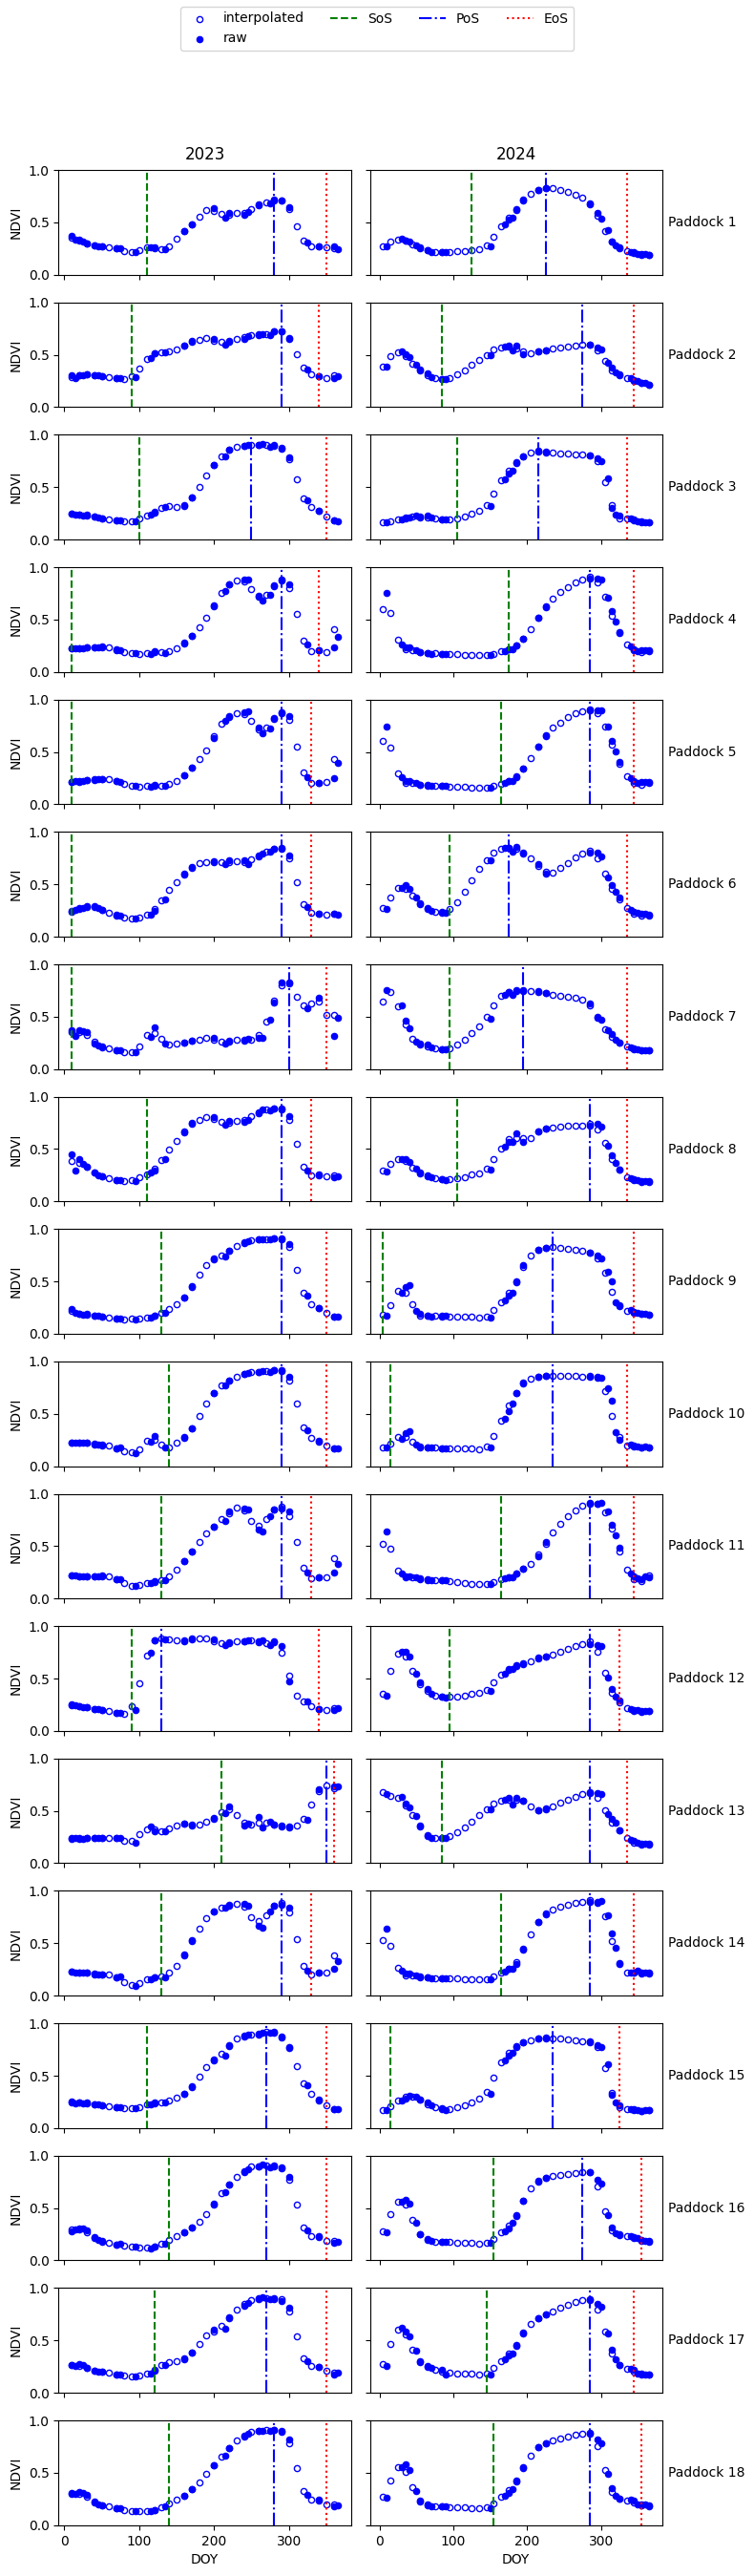

In [21]:
fig = plot_paddock_year_phenology_with_raw(
    phenology_results,
    ds_paddocks_resample_years,
    ds_paddocks,
    variable="NDVI"
)

fig.savefig(out_dir+stub+"_paddock_year_phenology_"+which_var+".svg", format="svg", bbox_inches="tight")

## More analysis

Below is stuff that is interesting to keep in the notebook but not neccesary to move into the .py script

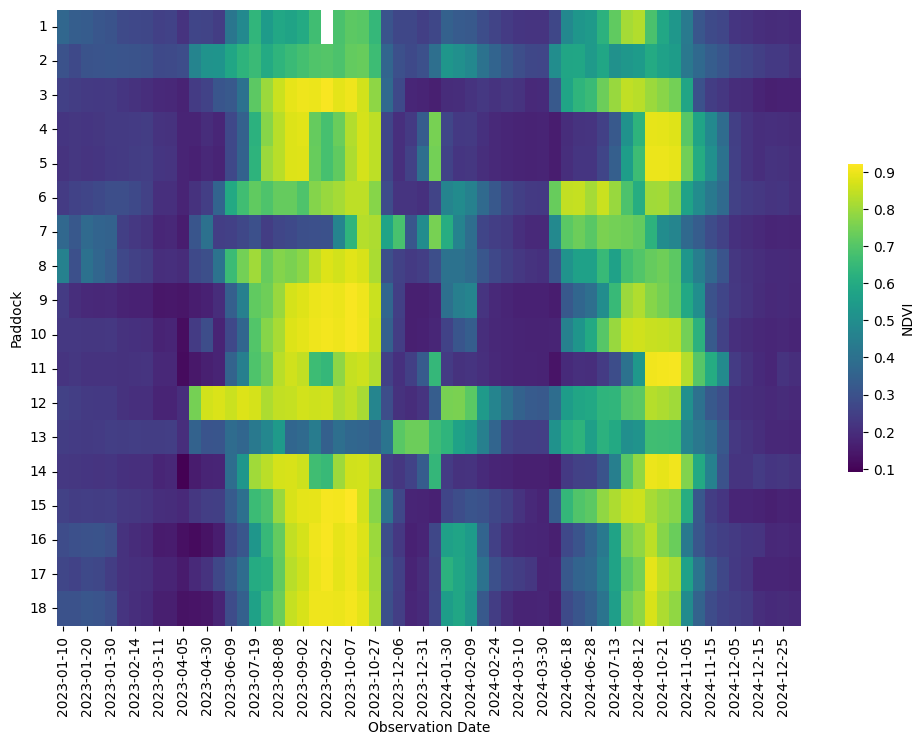

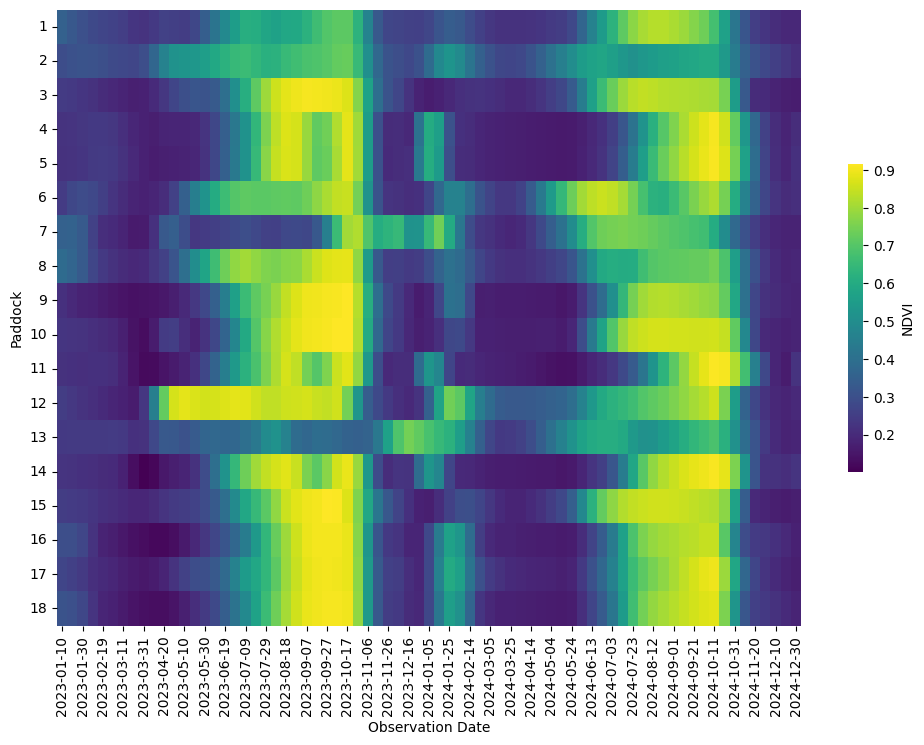

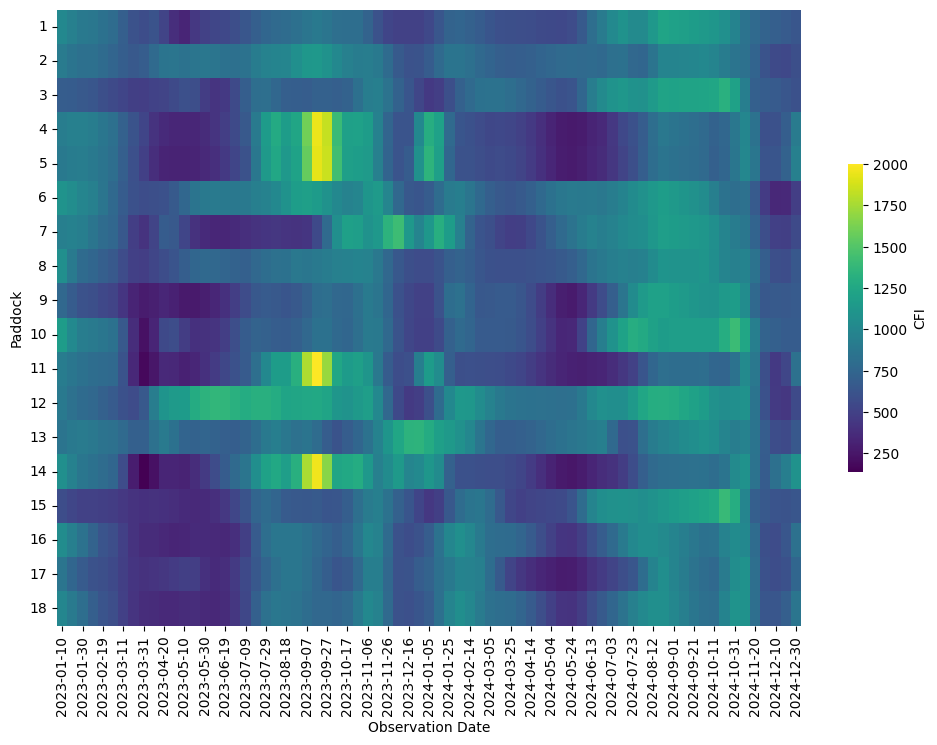

In [22]:
plot_heatmap(ds_paddocks, 'NDVI')
plot_heatmap(ds_paddocks_resample, 'NDVI')
# easy to predict which paddocks had canola
#plot_heatmap(ds_paddocks_resample_years[2023], 'CFI')
plot_heatmap(ds_paddocks_resample, 'CFI')

/jobfs/144414368.gadi-pbs/ipykernel_1474076/2248241981.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_units = ds.dims[unit_dim]    # total paddocks


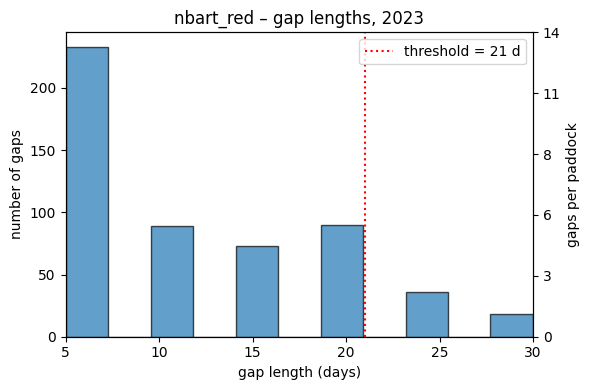

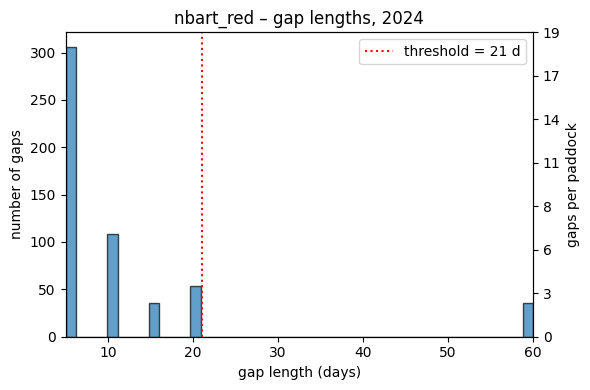

In [23]:
### Purpose of this function is to explore missing data in paddock time series. 


import numpy as np
import xarray as xr
import matplotlib.pyplot as plt


def plot_gap_lengths_by_year(ds: xr.Dataset,
                             var: str = "nbart_red",
                             *,
                             unit_dim: str = "paddock",
                             time_dim: str = "time",
                             min_gap_days: int = 1,
                             bins: int | str = "auto",
                             figsize: tuple[int, int] = (6, 4),
                             show: bool = True) -> dict[int, list[int]]:
    """
    Histogram of calendar-day gaps between successive valid observations.

    • Left y-axis  : absolute count of gaps.
    • Right y-axis : count ÷ number-of-paddocks (tick labels rounded).

    A red dotted vertical line marks `min_gap_days`; x-axis spans [min, max].
    """
    if var not in ds.data_vars:
        raise KeyError(f"{var!r} not found in dataset.")

    da = ds[var]
    n_units = ds.dims[unit_dim]    # total paddocks

    def _gaps_in_days(times: np.ndarray) -> np.ndarray:
        if times.size < 2:
            return np.empty(0, dtype=int)
        deltas = np.diff(np.sort(times.astype("datetime64[D]")))
        return deltas.astype("timedelta64[D]").astype(int)

    gap_dict: dict[int, list[int]] = {}

    for yr, da_year in da.groupby(f"{time_dim}.year"):
        gaps_all: list[int] = []
        for unit in da_year[unit_dim]:
            times = da_year.sel({unit_dim: unit}).dropna(time_dim)[time_dim].values
            gaps_all.extend(_gaps_in_days(times))

        gap_dict[yr] = [g for g in gaps_all if g >= min_gap_days]

        if show:
            fig, ax = plt.subplots(figsize=figsize)

            # histogram
            counts, edges, _ = ax.hist(gaps_all, bins=bins,
                                       edgecolor="black", alpha=0.7)

            # secondary y-axis: same scale, labels = counts/n_units (rounded)
            ax2 = ax.twinx()
            ax2.set_ylim(ax.get_ylim())
            primary_ticks = ax.get_yticks()
            ax2.set_yticks(primary_ticks)
            ax2.set_yticklabels([str(int(round(y / n_units))) for y in primary_ticks])
            ax2.set_ylabel("gaps per paddock")

            # red dotted threshold
            ax.axvline(min_gap_days, color="red", linestyle="dotted",
                       linewidth=1.5, label=f"threshold = {min_gap_days} d")

            # axis limits
            if gaps_all:
                ax.set_xlim(min(gaps_all), max(gaps_all))
            else:
                ax.set_xlim(0, 1)

            ax.set_xlabel("gap length (days)")
            ax.set_ylabel("number of gaps")
            ax.set_title(f"{var} – gap lengths, {yr}")
            ax.legend(loc="upper right")

            plt.tight_layout()
            plt.show()

    return gap_dict

gap_stats = plot_gap_lengths_by_year(ds_paddocks,
                                     var="nbart_red",
                                     min_gap_days=21)
# Next time, the threshold should indicate a red dotted line, and the domain should cover min to max. 